# 0.0 - Imports

In [103]:
# Bibliotecas
import pandas     as pd
import numpy      as np
import inflection
import seaborn    as sns
import umap.umap_ as umap

from IPython.display     import HTML

from matplotlib          import pyplot as plt

from plotly              import express

from sklearn             import cluster
from sklearn             import metrics

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 - Helper Functions

In [25]:
snakecase = lambda x: inflection.underscore(x)

# Configurações de Layout
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = (24,9)
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container {width:90% ! important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 - Carregamento dos dados

In [26]:
# Carregar os dados para análise.
df = pd.read_csv('../data/raw/Ecommerce.csv', encoding = 'unicode_escape').drop(columns=['Unnamed: 8'])

# 1.0 - Descrição dos Dados

In [27]:
df1 = df.copy()

## 1.1 - Atributos

**InvoiceNo:** Número que identifica a transação da compra.

**StockCode:** Código do produto.

**Description:** Descrição do produto.

**Quantify:** Quantidade comprada do produto.

**InvoiceDate:** Data em que a transação foi efetuada.

**UnitPrice:** Preço unitário do produto comprado.

**CustomerID:** Número que identifica o cliente.

**Country:** País em que o cliente realizou a transação.

## 1.2 - Dimensão dos Dados

In [28]:
rows = df1.shape[0]
columns = df1.shape[1]

print(f'Número de Linhas: {rows}.')
print(f'Número de Colunas: {columns}')

Número de Linhas: 541909.
Número de Colunas: 8


## 1.3 - Renomear Nome das Colunas

In [29]:
# Renomear Lista
lista = df1.columns.tolist()

# Nome das novas colunas
new_columns = [snakecase(x) for x in lista]

# renomear as colunas
df1.columns = new_columns

## 1.4 - Check NA

In [30]:
# Verificação e existem dados nulos
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [31]:
# Dropagem das linhas que possuem NA
df1 = df1.dropna()

# Verificação
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.5 - Natureza das Variáveis

In [32]:
# Verificando a tipagem dos dados.
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.6 - Limpeza dos Dados

In [33]:
# Nome dos produtos em tamanho minúsculo.
df1['description'] = df1['description'].apply(lambda x: x.lower())

# Nome dos paíse em tamanho minúsculo.
df1['country'] = df1['country'].apply(lambda x: x.lower())

## 1.7 - Mudança de Variáveis

In [36]:
# Mudança de tipagem do invoice_date
df1['invoice_date'] = df1['invoice_date'].apply(lambda x: pd.to_datetime(x))

# customer_id
df1['customer_id'] = df1['customer_id'].apply(lambda x: str(int(x)))

## 1.8 - Estatística Descritiva 

# 2.0 - Feature Engineering

In [58]:
df2 = df1.copy()

## 2.1 - Criação das Features


In [59]:
# ----------------- Construção do DataFrame do Modelo RFM -------------------------

# Dataframe Referência
df_ref = df2.drop(['invoice_no', 'stock_code', 
                   'description', 'quantity', 
                   'invoice_date','unit_price', 'country'], axis=1).copy()

# Remover duplicidades 
df_ref = df_ref.drop_duplicates().reset_index(drop=True)

# ------ Construção da Feature Recency ---------

df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy() 

# Merge do df_recency com o dataframe referência.
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# ------ Construção da Feature Frequencily -------

df_frequencily = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_frequencily = df_frequencily.rename(columns={'invoice_no' : 'frequencily'})

# Merge do df_frequencily com o dataframe referência.
df_ref = pd.merge(df_ref, df_frequencily, on='customer_id', how='left')

# ------ Construção da Feature Monetary -------

df2['total_by_product'] = df2['quantity'] * df2['unit_price']

df_monetary = df2[['customer_id', 'total_by_product']].groupby('customer_id').sum().reset_index()
df_monetary = df_monetary.rename(columns = {'total_by_product' : 'gross_revenue'})

# Merge do df_monetary com o dataframe referência.
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# ---------- Construção da Feature Average Ticket ---------------------

df_avg_ticket = df2[['customer_id', 'total_by_product']].groupby('customer_id').mean().reset_index()
df_avg_ticket = df_avg_ticket.rename(columns={'total_by_product':'avg_ticket'})
df_avg_ticket['avg_ticket'] = df_avg_ticket['avg_ticket'].apply(lambda x: round(x, 2))

# Merge do df_monetary com o dataframe referência.
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

In [63]:
df3 = df2.copy()

In [64]:
df4 = df3.copy()

In [65]:
df5 = df4.copy()

In [66]:
df6 = df5.copy()

# 3.0 - Hiperparameter FineTunning

In [67]:
df7 = df6.copy()

In [68]:
# Ajuste dos Dados os modelos
df_treino = df_ref.drop(columns=['customer_id'])

# quantidade de cluster
clusters = [2, 3, 4, 5, 6, 7]

## 3.1 - Within-Cluster Sum of Square (WSS)

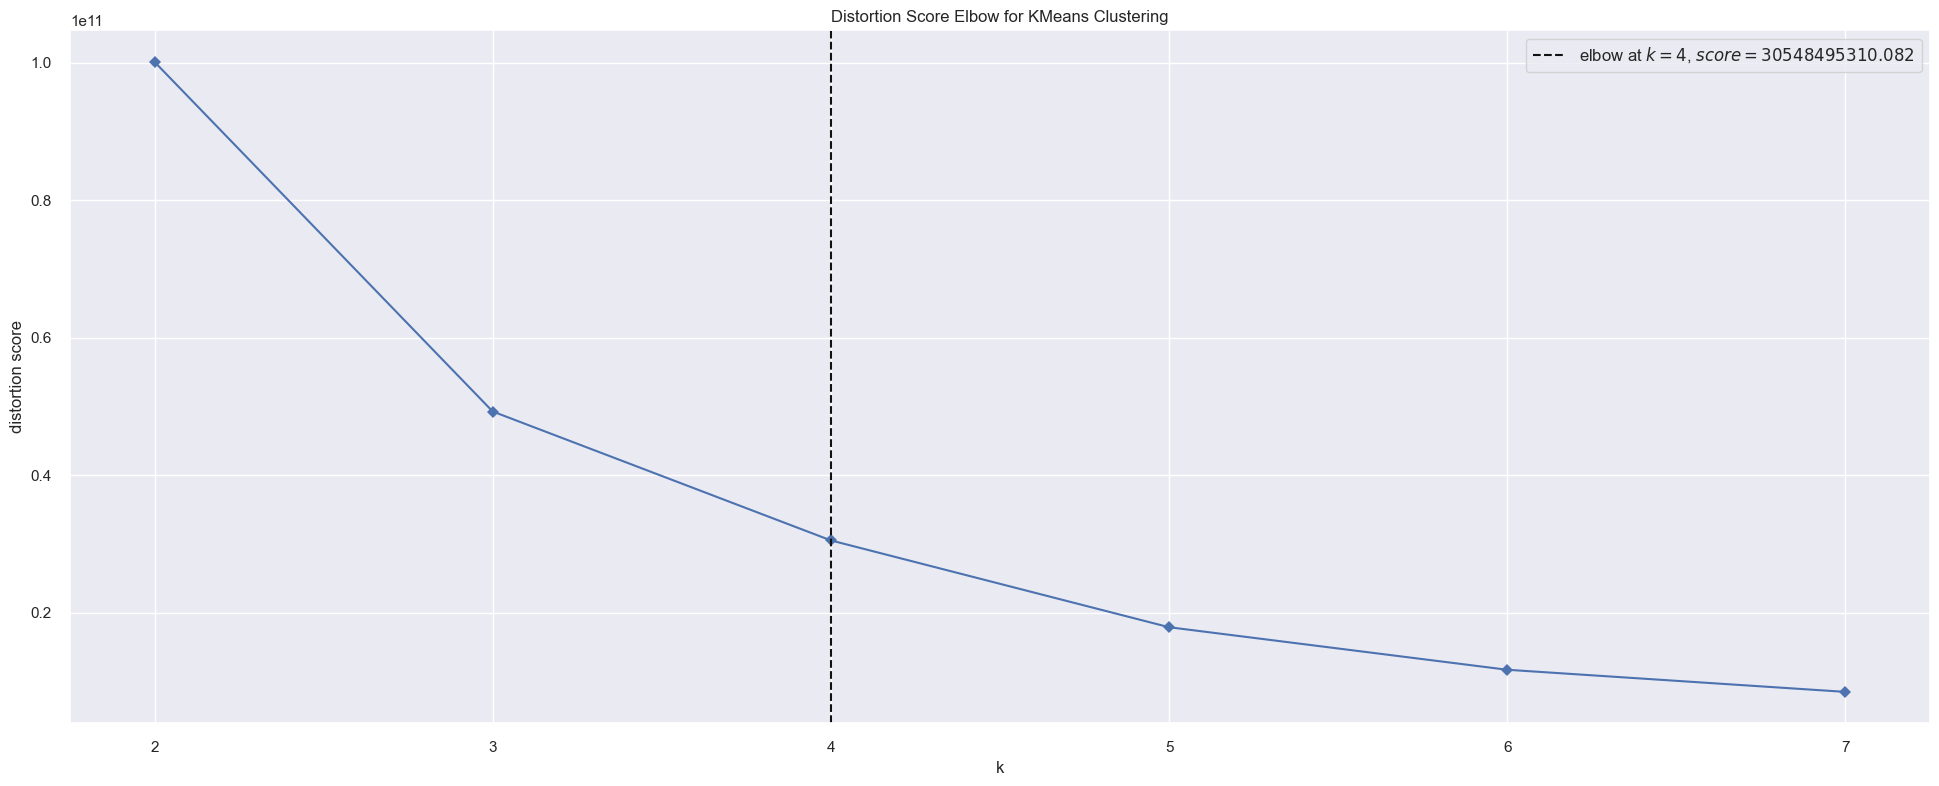

In [76]:
# model definition
#kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Usando o pacote yellowbrick para nos ajudar a determinar o melhor k de cluster.
graph_wss = KElbowVisualizer(cluster.KMeans(), k=clusters, timings=False)
graph_wss.fit(df_treino)
graph_wss.show();

## 3.2 Silhouette Score

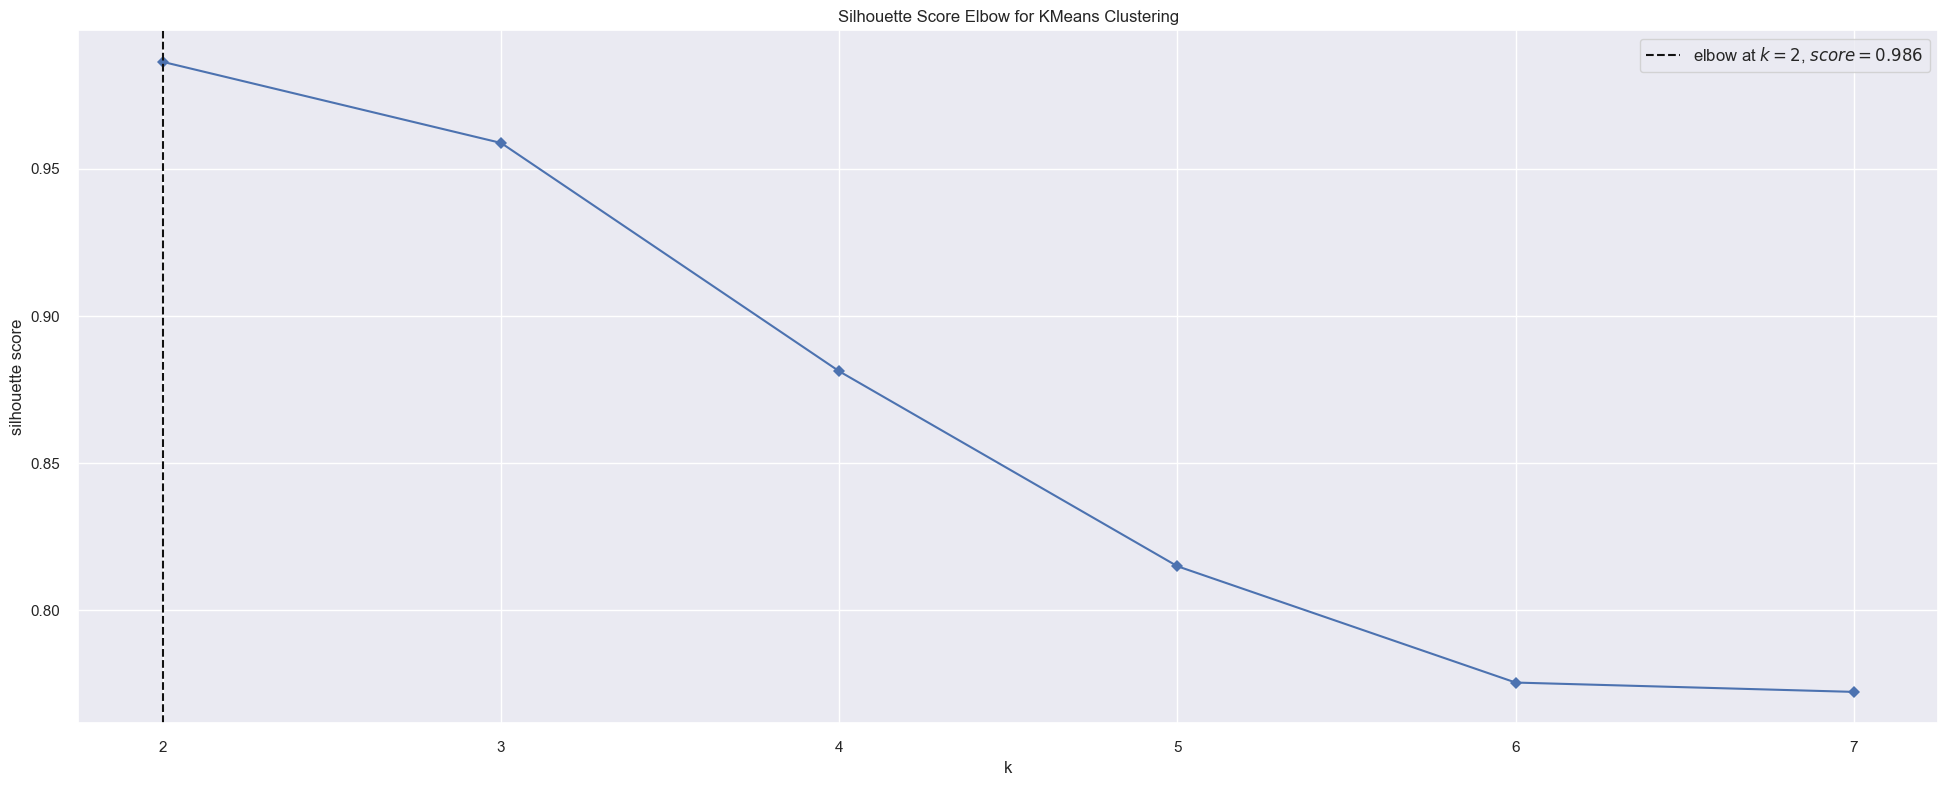

In [77]:
# Usando o pacote yellowbrick para nos ajudar a determinar o melhor k de cluster.
graph_silhoutte = KElbowVisualizer(cluster.KMeans(), k=clusters, metric='silhouette', timings=False)
graph_silhoutte.fit(df_treino)
graph_silhoutte.show();

## 3.3 - Analise da Silhouette

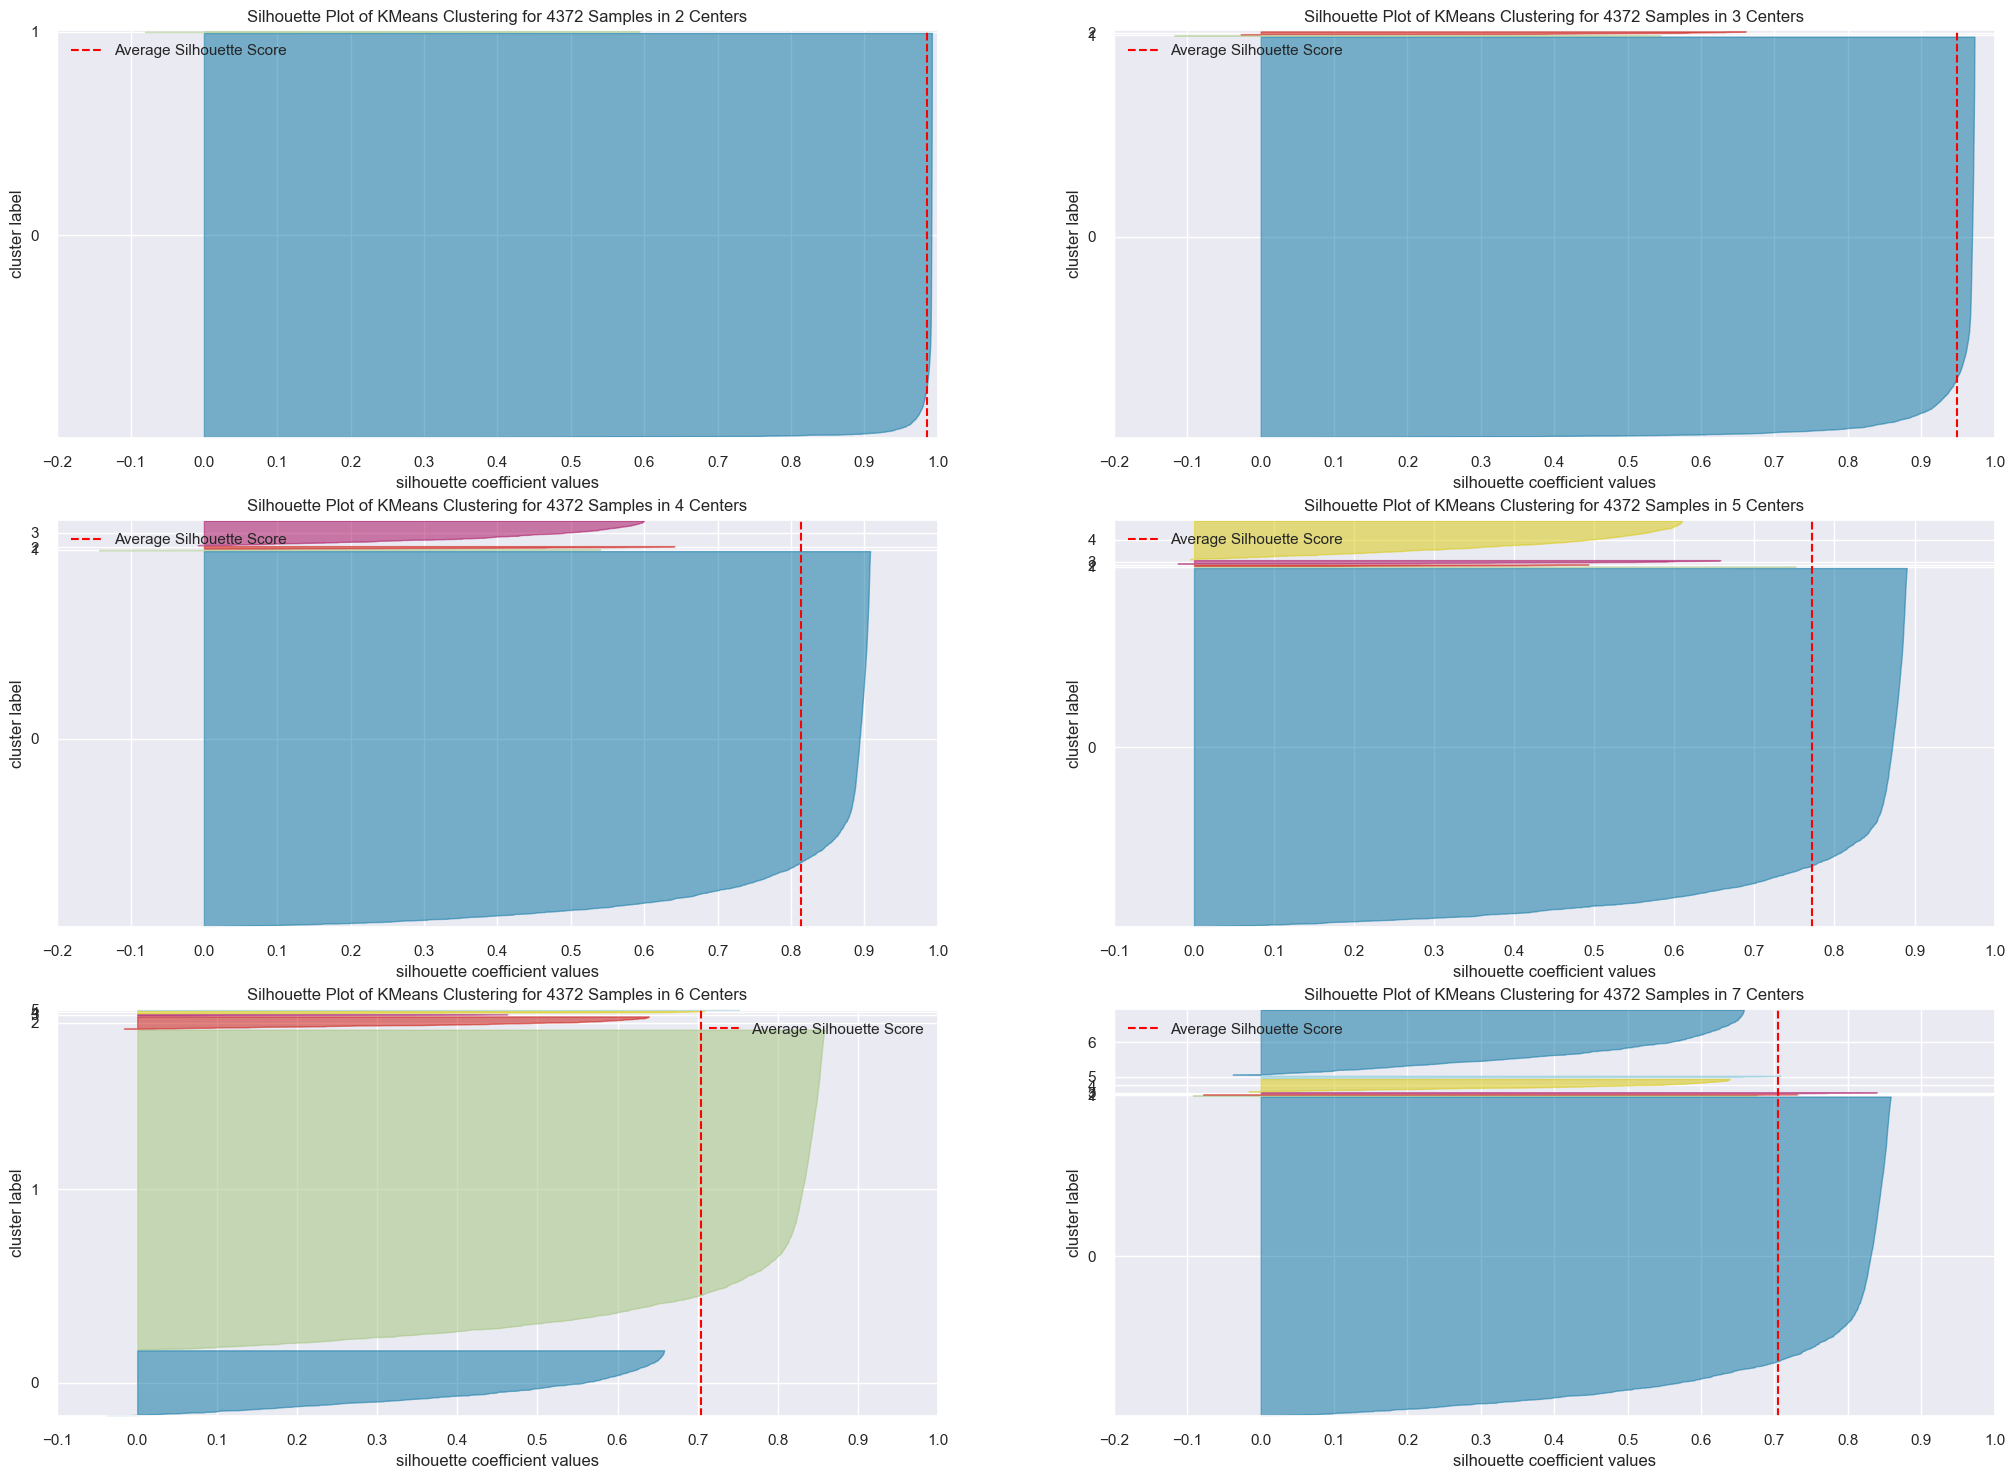

In [87]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    # Definição do modelo e seus parâmetros
    kmeans = cluster.KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=42)
    
    # parâmetros para determinar as posições em que serão plotados os gráficos
    linha, coluna = divmod(k, 2)

    # Plotagem da Análise da Silhouette
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[linha -1][coluna])
    visualizer.fit(df_treino)
    visualizer.finalize()


# 4.0 - Model Training

## 4.1 - K-means

In [90]:
# Modelo definido
k=4
kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Treino do Modelo
kmeans.fit(df_treino)

# clustering
labels = kmeans.labels_

### 4.1.2 - K-means CrossValidation

In [91]:
# WSS Score
print(f'WSS Score: {kmeans.inertia_}.')

# Silhouette Score
print(f'Silhouette Score: {metrics.silhouette_score(df_treino, labels)}')

WSS Score: 40056506747.93852.
Silhouette Score: 0.8139972030280034


# 5.0 - Cluster Analysis

In [93]:
df9 = df_treino.copy()

# Rotulando cada cliente de acordo o o seu cluster
df9['cluster'] = labels

## 5.1 - Inspeção por Visualização - Analysis Silhouette

c:\users\xcell\repositorio\projects\project_clustering_customers\.clustering\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


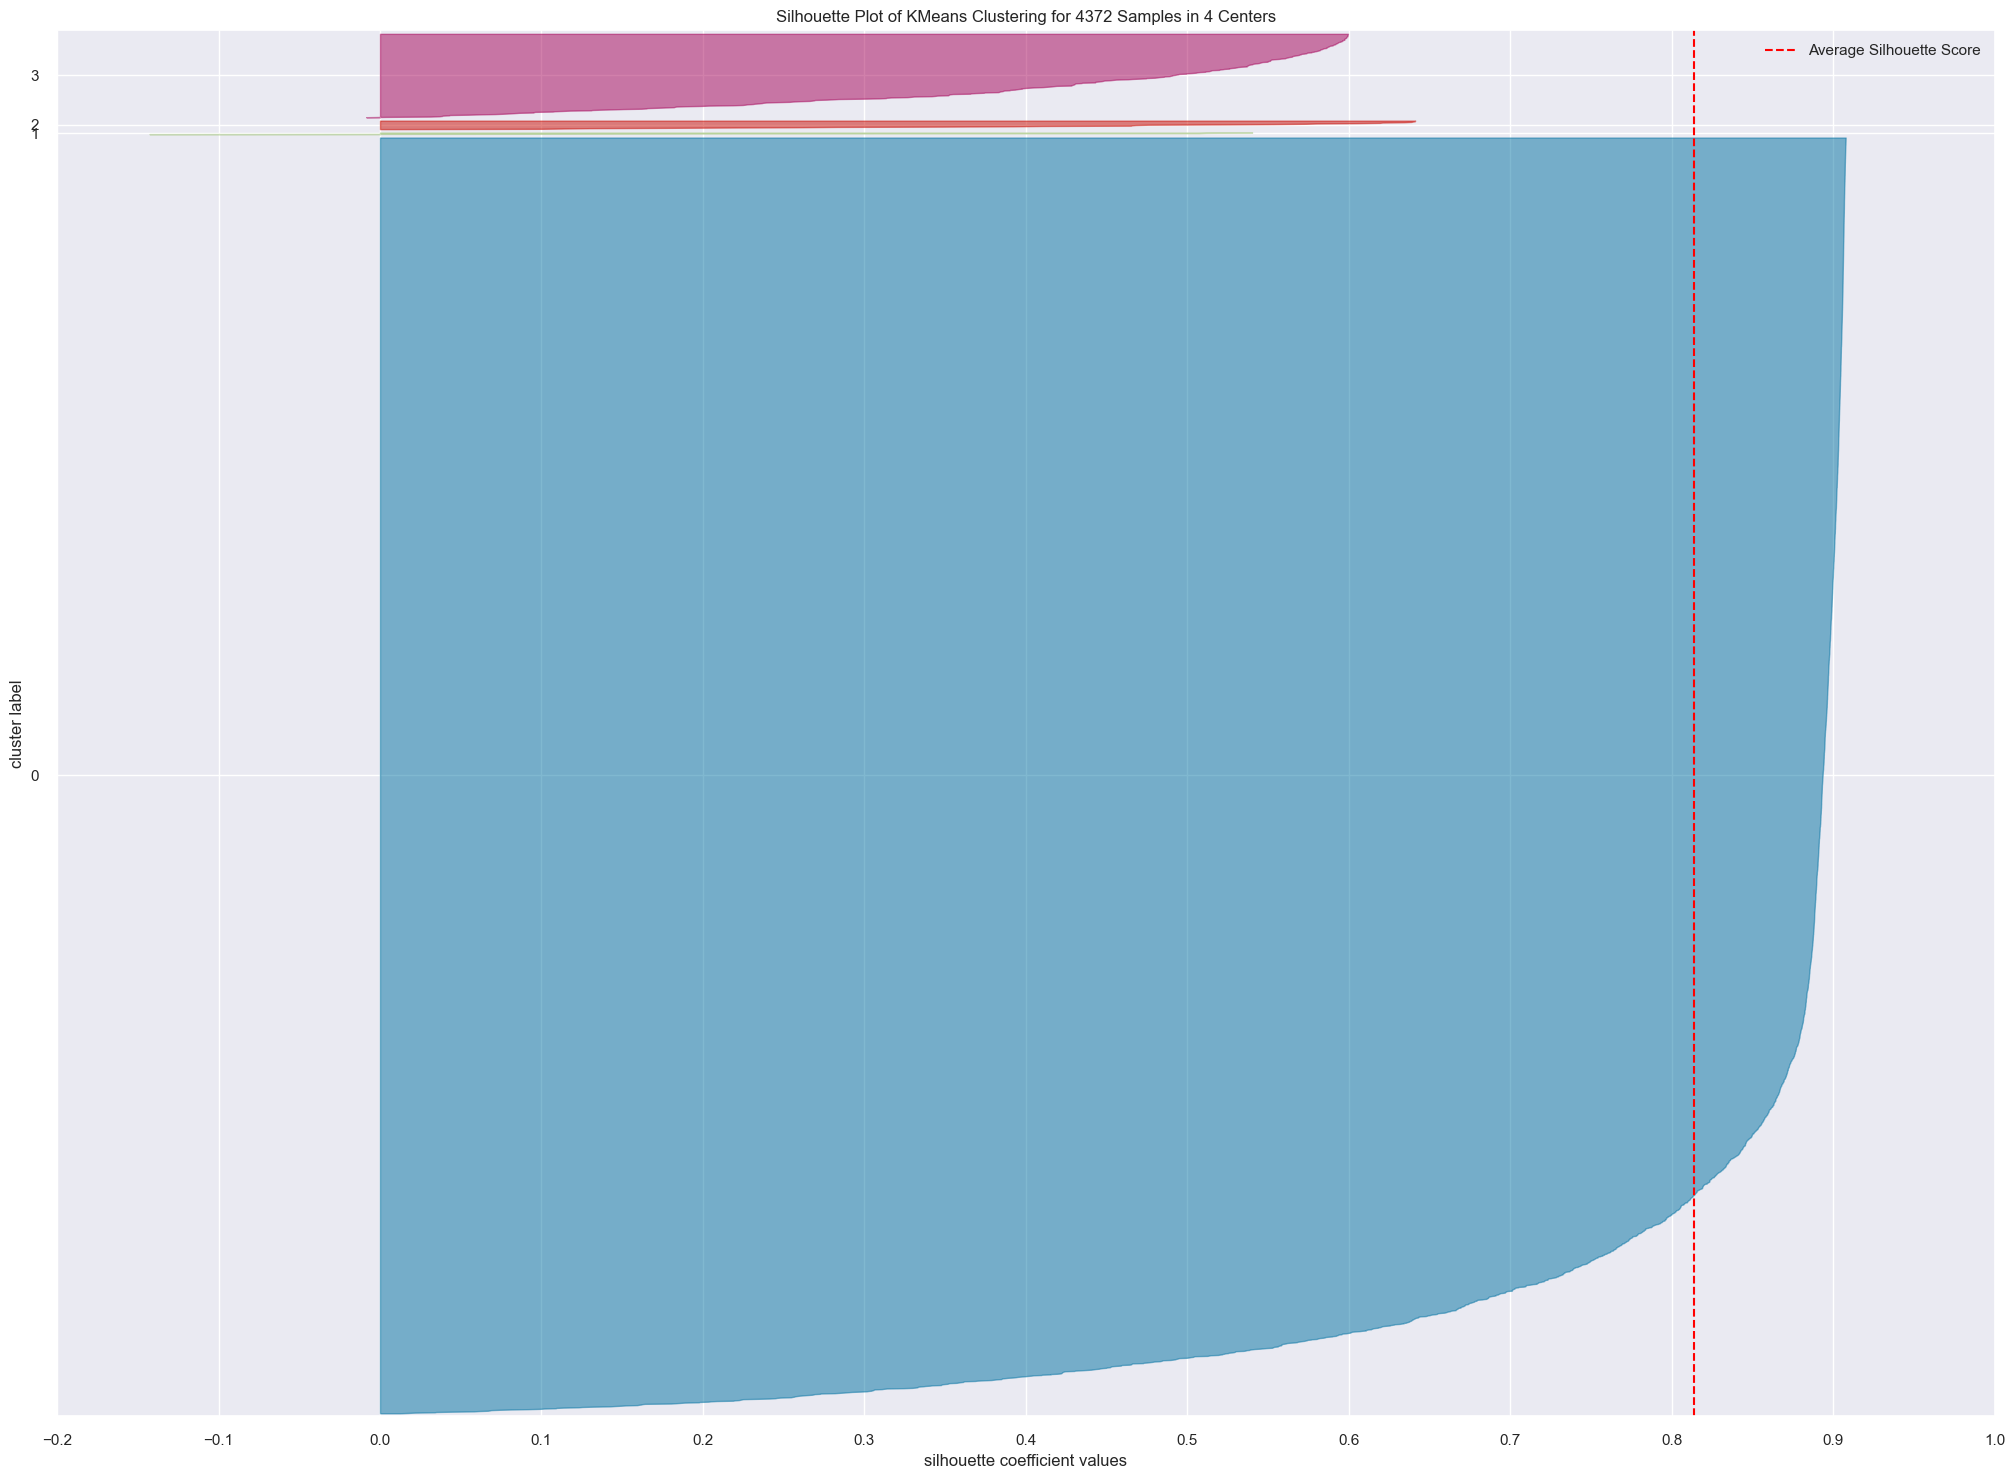

In [96]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_treino)
visualizer.finalize()

## 5.2 - Inspeção por Visualização: 2D Plot

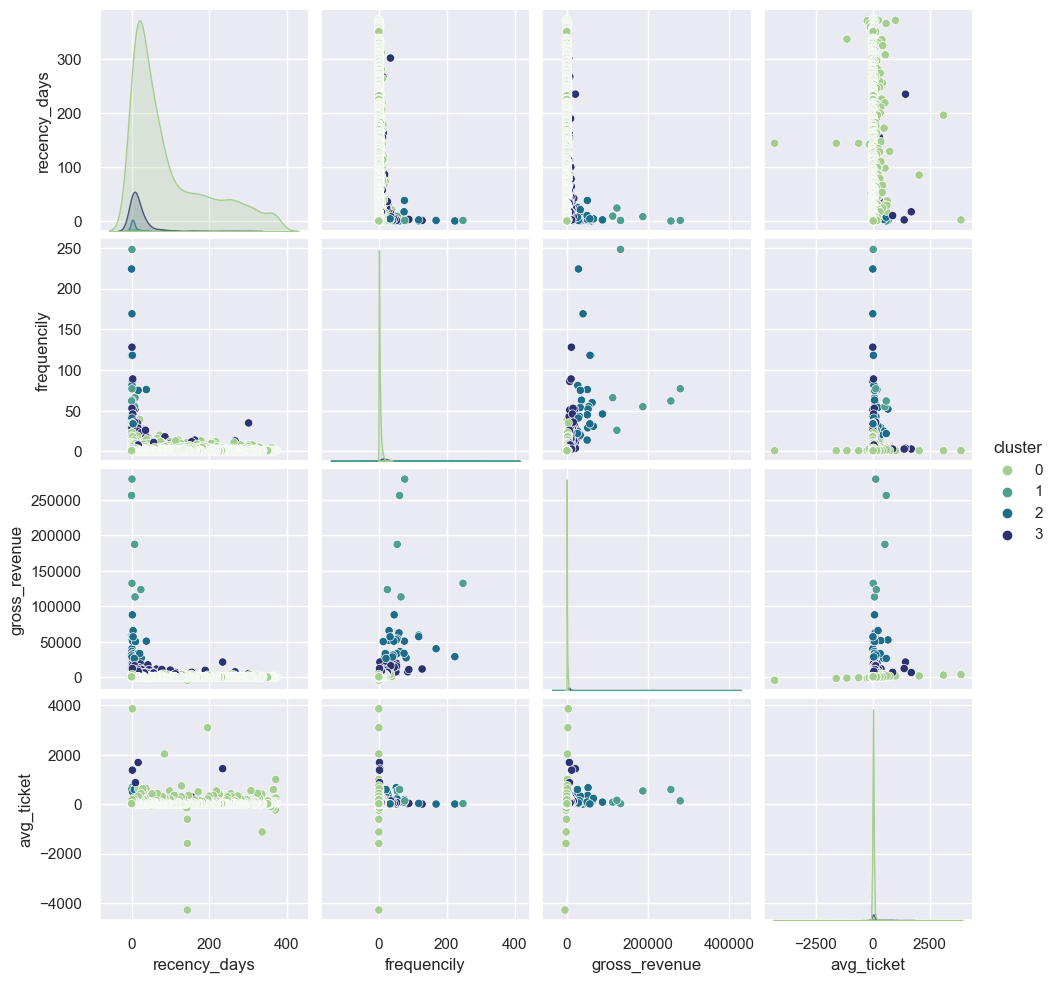

In [100]:
df_analysis = df9.copy()
sns.pairplot(df_analysis, hue='cluster', palette='crest')

## 5.3 - UMAP

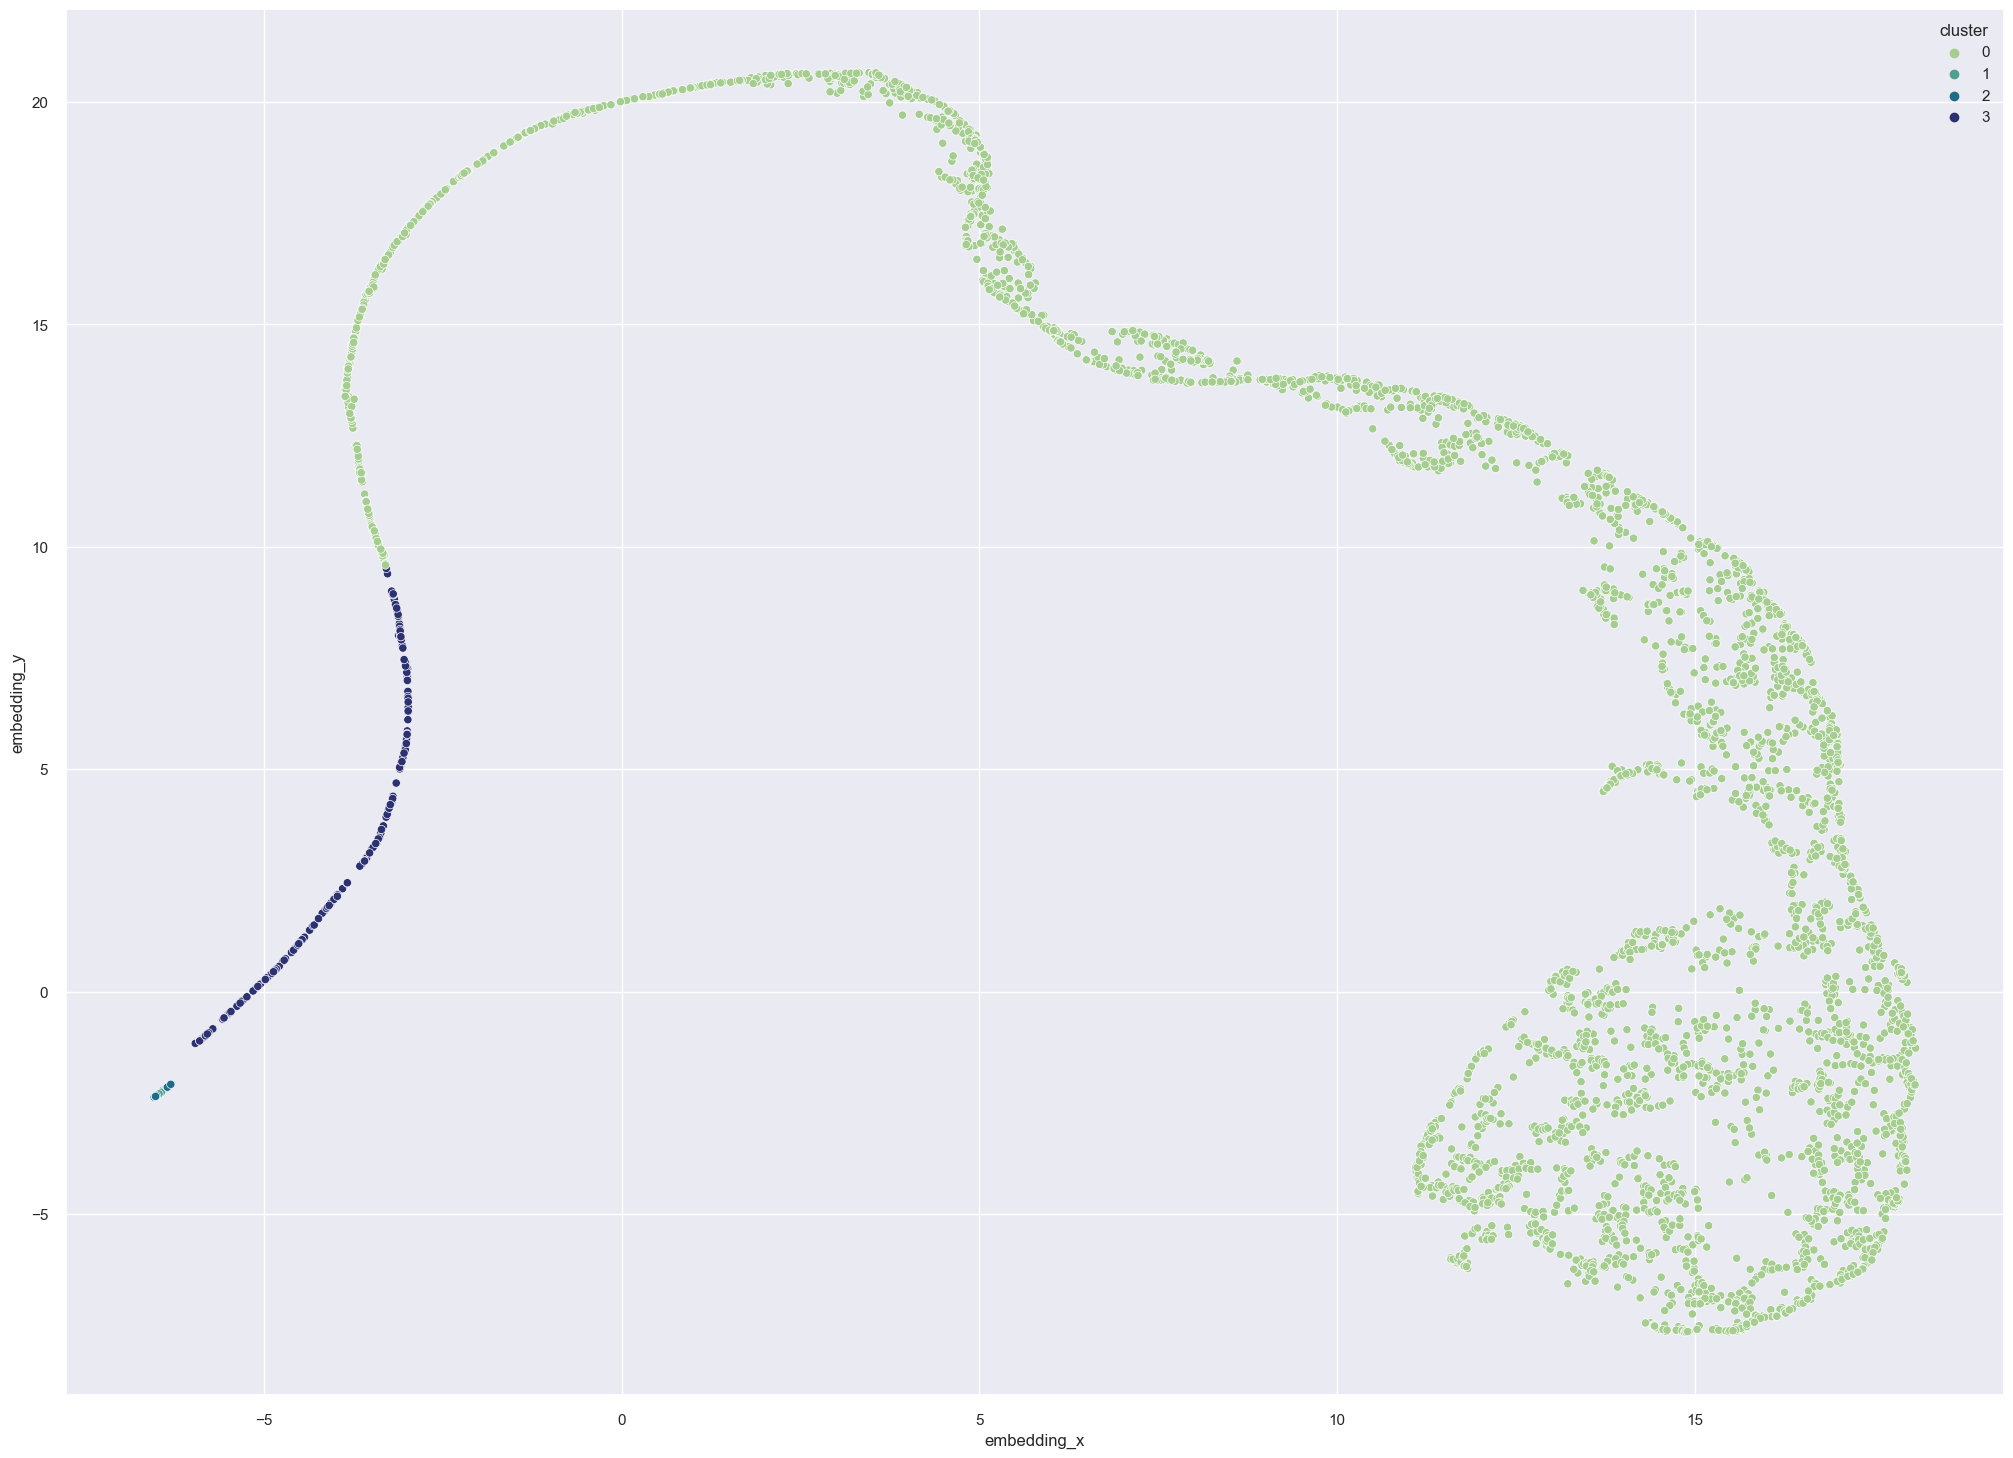

In [108]:
#  ------------ Preparação e treino do modelo ------------

reducer = umap.UMAP(n_neighbors=30, random_state=42)
embedding = reducer.fit_transform(df_treino)

# --------------------- embedding -----------------------

# Projeção do eixo x
df_analysis['embedding_x'] = embedding[ : , 0] 

# projeção do eixo y
df_analysis['embedding_y'] = embedding[ : , 1] 

# -------------------- Plotagem ---------------------------

# Plotagem das projeções
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette='crest', data=df_analysis);

## 5.4 - Perfil dos Cluster

In [109]:
# rotular cada cliente de acordo com o seu cluster
df_ref['cluster'] = labels

# quantidade de clientes por cluster
df_cluster = df_ref[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id':'number_customers'})

# Media de Faturamento por Cluster
df_mean_gross_revenue = df_ref[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index().rename(columns= {'gross_revenue':'mean_gross_revenue'})

# Media de Frequência de Compras
df_mean_frequencily= df_ref[['frequencily', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'frequencily':'mean_frequencily'})

# Media de Recências
df_mean_recency_days= df_ref[['recency_days', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'recency_days':'mean_recency_days'})

# Media das compras
df_mean_avg_ticket = df_ref[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'avg_ticket':'mean_avg_ticket'})

# Junção de todos os dados em uma única tabela.
df_aux = pd.merge(df_cluster, df_mean_recency_days, how='inner', on='cluster')
df_aux = pd.merge(df_aux, df_mean_frequencily, how='inner', on='cluster')
df_aux = pd.merge(df_aux, df_mean_gross_revenue, how='inner', on='cluster')
tabela_final = pd.merge(df_aux, df_mean_avg_ticket, how='inner', on='cluster')

# Criação da coluna que nos dá o percentual de clientes em cada cluster.
tabela_final['number_customer_percentual'] = round((tabela_final['number_customers']/tabela_final['number_customers'].sum())*100, 2)

 
# -------------------------------    Reajustes da tabela_final ----------------------------------

# reajuste recência
tabela_final['mean_recency_days'] = tabela_final['mean_recency_days'].apply(lambda x: int(x))

# reajuste ferquencia
tabela_final['mean_frequencily'] = tabela_final['mean_frequencily'].apply(lambda x: int(x))

# reajuste faturamento
tabela_final['mean_gross_revenue'] = tabela_final['mean_gross_revenue'].apply(lambda x: round(x, 2))

# reajuste faturamento
tabela_final['mean_avg_ticket'] = tabela_final['mean_avg_ticket'].apply(lambda x: round(x, 2))

# 6.0 - Relatório Final

## Tabela

In [110]:
tabela_final

,cluster,number_customers,mean_recency_days,mean_frequencily,mean_gross_revenue,mean_avg_ticket,number_customer_percentual
0,0,4071,96,3,946.70,25.36,93.12
1,1,6,7,89,182181.98,253.63,0.14
2,2,28,6,57,42614.39,162.86,0.64
3,3,267,20,19,8089.03,62.78,6.11


## Cluster 0

In [115]:
print(f'Número Clientes: {tabela_final.loc[0, "number_customers"]}.')
print(f'Média de Recência: {tabela_final.loc[0, "mean_recency_days"]} dias.')
print(f'Média de Frequência: {tabela_final.loc[0, "mean_frequencily"]}.')
print(f'Média de Faturamento: US$ {tabela_final.loc[0, "mean_gross_revenue"]}.')
print(f'Média de Ticket Médio: US$ {tabela_final.loc[0, "mean_avg_ticket"]}.')
print(f'Número de clientes em percentual: {tabela_final.loc[0, "number_customer_percentual"]}%.')

Número Clientes: 4071.
Média de Recência: 96 dias.
Média de Frequência: 3.
Média de Faturamento: US$ 946.7.
Média de Ticket Médio: US$ 25.36.
Número de clientes em percentual: 93.12%.


## Cluster 1

In [116]:
print(f'Número Clientes: {tabela_final.loc[1, "number_customers"]}.')
print(f'Média de Recência: {tabela_final.loc[1, "mean_recency_days"]} dias.')
print(f'Média de Frequência: {tabela_final.loc[1, "mean_frequencily"]}.')
print(f'Média de Faturamento: US$ {tabela_final.loc[1, "mean_gross_revenue"]}.')
print(f'Média de Ticket Médio: US$ {tabela_final.loc[1, "mean_avg_ticket"]}.')
print(f'Número de clientes em percentual: {tabela_final.loc[1, "number_customer_percentual"]}%.')

Número Clientes: 6.
Média de Recência: 7 dias.
Média de Frequência: 89.
Média de Faturamento: US$ 182181.98.
Média de Ticket Médio: US$ 253.63.
Número de clientes em percentual: 0.14%.


## Cluster 2

In [117]:
print(f'Número Clientes: {tabela_final.loc[2, "number_customers"]}.')
print(f'Média de Recência: {tabela_final.loc[2, "mean_recency_days"]} dias.')
print(f'Média de Frequência: {tabela_final.loc[2, "mean_frequencily"]}.')
print(f'Média de Faturamento: US$ {tabela_final.loc[2, "mean_gross_revenue"]}.')
print(f'Média de Ticket Médio: US$ {tabela_final.loc[2, "mean_avg_ticket"]}.')
print(f'Número de clientes em percentual: {tabela_final.loc[2, "number_customer_percentual"]}%.')

Número Clientes: 28.
Média de Recência: 6 dias.
Média de Frequência: 57.
Média de Faturamento: US$ 42614.39.
Média de Ticket Médio: US$ 162.86.
Número de clientes em percentual: 0.64%.


## Cluster 3

In [118]:
print(f'Número Clientes: {tabela_final.loc[3, "number_customers"]}.')
print(f'Média de Recência: {tabela_final.loc[3, "mean_recency_days"]} dias.')
print(f'Média de Frequência: {tabela_final.loc[3, "mean_frequencily"]}.')
print(f'Média de Faturamento: US$ {tabela_final.loc[3, "mean_gross_revenue"]}.')
print(f'Média de Ticket Médio: US$ {tabela_final.loc[3, "mean_avg_ticket"]}.')
print(f'Número de clientes em percentual: {tabela_final.loc[3, "number_customer_percentual"]}%.')

Número Clientes: 267.
Média de Recência: 20 dias.
Média de Frequência: 19.
Média de Faturamento: US$ 8089.03.
Média de Ticket Médio: US$ 62.78.
Número de clientes em percentual: 6.11%.
